 # Systems:
 - Gene network switch (pg 120, Ch 4.3)
 - Can also do repressilator model w/ 6 equations?
 - Morris-Lecar Model (pg 154 Ch 5.5 & end of Ch 3.4)
 - 1D ODE in Ch 5.1
 - Maybe check out linear systems of diff eq in 5.3.3 pg 145
 
## To-do
##### GENERAL
 - update variable names to be more descriptive/not be the same x_train all over
 - watch pySINDy tutorials to learn how to use it
 - Hadlock lab cloud computing work?

##### TOPICAL GOALS
 - Work done on network switch, plots to be used for proposal since it's been 'settled'
 - MSE: https://stackoverflow.com/questions/16774849/mean-squared-error-in-numpy
 - Look at colorednoise library for different noise `cn.powerlaw_psd_gaussian(beta, 10000)*.73` for noise that follows the np.normal thing for gaussian noise and a bit lower for pink. `* 0.73` corresponds to sigmaVal, there is some error though
 - Issue with ODE solver where it blows up. Numerical error dividing small values or soln has huge derivative?? Need to fix, lengthens computation time and lowers accuracy of model.

##### Questions
 - Morris-Lecar function library; how to deal with parameter in helper functions/how to identify them in pySINDy since it only seems to cover coeffs? ANSWER: BAYESIAN (Bayesian logical data analysis for the physical sciences)?? LIKELIHOOD FUNCTION?? JUST DO MANY DIFFERENT FUNCTIONS THAT CORRESPOND TO DIFFERENT PARAMETER COMBOS 
 
##### Poster Notes
 - Why equations over descriptive models? Outlined in math biology book
 - 

In [1]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from scipy.integrate import solve_ivp
import pysindy as ps
from sklearn.metrics import mean_squared_error
import colorednoise as cn
# from matplotlib.cm import rainbow
# from scipy.io import loadmat
# V correct RMSE method, 6 is prefactor
# rmse_test = np.sqrt(np.square(np.subtract(A, B)).sum()) / 6


In [63]:
#### test cell
num = 2
mu = np.zeros(num)
sigma = np.zeros((num, num))
sigmaVal = .9
np.fill_diagonal(sigma, sigmaVal)
#sigma
result = np.random.multivariate_normal(mu, sigma**2, (100, 100))
#noise123 = netswitch_train_multi + result
#print(np.max(result))
#print(np.random.rand(n_of_ic, 2) * 10)
#A = [1, 2, 3]
#B = [4, 5, 6]
# testing of different MSE methods
#print(mean_squared_error(A, B))
#print(np.square(np.subtract(netswitch_train_multi, noise123)).mean())
#print(((np.array(A) - B) ** 2).mean(axis=None))

# accurate enough for noise? Pink noise behaving weird
beta = 0 # the exponent
samples = 2**18 # number of samples to generate
y = cn.powerlaw_psd_gaussian(beta, (100, 400, 2)) * sigmaVal + 0.02
#print(np.max(y))
#"""
y_list = []
result_list = []
for i in range(1000):
    y_temp = (cn.powerlaw_psd_gaussian(beta, (100, 100, 2)) * (sigmaVal + 0.03))
    result_temp = (np.random.multivariate_normal(mu, sigma**2, (100, 100)))
    y_list.append(y_temp)
    result_list.append(result_temp)
print(f"colorednoise mean = {np.mean(y_list)}")
print(f"multivariate_normal mean = {np.mean(result_list)}")
#"""


colorednoise mean = 0.0002791739232625031
multivariate_normal mean = -0.00012368744374973619


## Gene Network Switch

In [2]:
# contains functions + basic parameters
a_u, a_v = 1, 1
beta, gamma = 2, 2
dudt = lambda u, v: -u + (a_u / (1+v**beta))
dvdt = lambda u, v: -v + (a_v / (1+u**gamma))
sigma = 0.01
sigma_list = np.linspace(0.001, 0.8, 10)
netswitch = lambda t, x: np.array([dudt(x[0], x[1]), dvdt(x[0], x[1])])
# 0-5 minus some value between 0-1, no negatives for IC?
n_of_ic = 1000
u_ic = np.random.random(size=n_of_ic) * 5 - np.random.random(size=n_of_ic)
v_ic = np.random.random(size=n_of_ic) * 5 - np.random.random(size=n_of_ic)

def plot_data_and_derivative(x, dt, deriv):
    feature_name = ["u", "v"]
    plt.figure(figsize=(20, 5))
    for i in range(2):
        plt.subplot(1, 2, i + 1)
        plt.plot(x[:, i], label=feature_name[i])
        plt.grid(True)
        plt.xlabel("t", fontsize=24)
        plt.xticks(fontsize=18)
        plt.yticks(fontsize=18)
        plt.legend(fontsize=24)
    x_dot = deriv(x, t=dt)
    plt.figure(figsize=(20, 5))
    for i in range(2):
        plt.subplot(1, 2, i + 1)
        plt.plot(x_dot[:, i], label=r"$\dot{" + feature_name[i] + "}$")
        plt.grid(True)
        plt.xlabel("t", fontsize=24)
        plt.xticks(fontsize=18)
        plt.yticks(fontsize=18)
        plt.legend(fontsize=24)
library_functions = [
    lambda x: x,
    lambda x: 1 / (1 + x**1),
    lambda x: 1 / (1 + x**2),
    lambda x: 1 / (1 + x**3),
    lambda x: 1 / (1 + x**4),
    lambda x: 1 / (1 + x**5)
]
library_function_names = [
    lambda x: x,
    lambda x: '1/(1 + ' + x + '^1)',
    lambda x: '1/(1 + ' + x + '^2)',
    lambda x: '1/(1 + ' + x + '^3)',
    lambda x: '1/(1 + ' + x + '^4)',
    lambda x: '1/(1 + ' + x + '^5)'
]
netswitch_library = ps.CustomLibrary(
    library_functions=library_functions, function_names=library_function_names
)

(u)' = -1.112 u + 5.802 1/(1 + u^2) + 4.783 1/(1 + v^2) + -4.630 1/(1 + u^3) + -3.122 1/(1 + v^3) + -8.863 1/(1 + u^4) + -5.796 1/(1 + v^4) + 7.845 1/(1 + u^5) + 5.346 1/(1 + v^5)
(v)' = -1.122 v + 5.139 1/(1 + u^2) + 5.554 1/(1 + v^2) + -3.459 1/(1 + u^3) + -4.611 1/(1 + v^3) + -5.523 1/(1 + u^4) + -8.604 1/(1 + v^4) + 5.135 1/(1 + u^5) + 7.753 1/(1 + v^5)
(5000, 2)


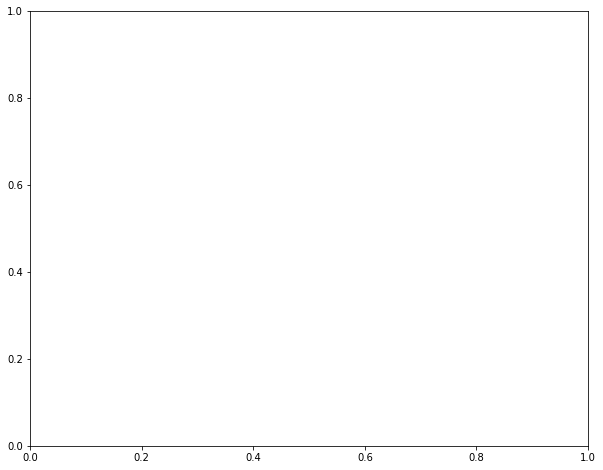

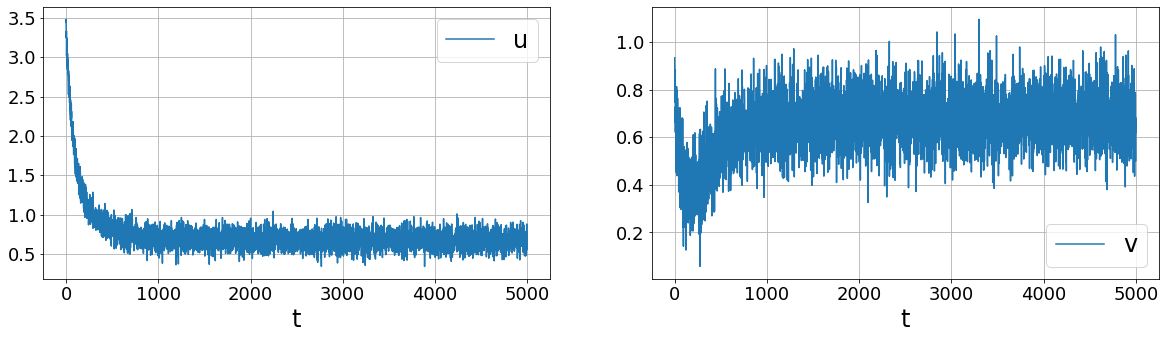

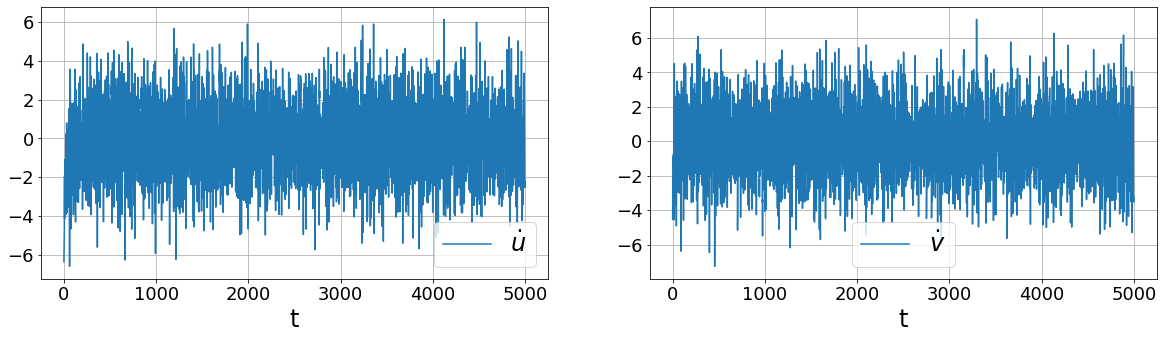

In [9]:
# Dynamic System #1 DMiB page 120
# Gene Network switch
u0 = 1
v0 = 1
T = 50
dt = 0.01
trange = np.array([0, T])
#tvals = np.arange(0, T + dt, dt)
tvals = np.linspace(0, T, 5000)
fig, axs = plt.subplots(figsize=(10,8))
netswitch_x0s = (np.random.rand(n_of_ic, 2) * 5 - np.random.rand(n_of_ic, 2))
netswitch_train_multi = []
n_of_ic = 1000

# creation of data/solution
for i in range(n_of_ic): 
    #x0 = np.array([u_ic[i], v_ic[i]])
    # solve Sys #1
    #soln = solve_ivp(netswitch, trange, x0, t_eval=tvals)
    #uSoln = soln.y[0,:].reshape(-1,1)
    #vSoln = soln.y[1,:].reshape(-1,1)
    # graph 
    #axs.plot(tvals, uSoln, "r", label="$u$", **plot_kws)
    #axs.plot(tvals, vSoln, "b", label="$v$", **plot_kws)
    
    # phase portrait
    #axs.plot(uSoln, vSoln, label=f"$u_0 = {round(v_ic[i], 3)}, v_0 = {round(v_ic[i], 3)}$", alpha=0.4)
    
    # pySINDy
    # data creation
    netswitch_train_temp = solve_ivp(
        netswitch, trange, netswitch_x0s[i], t_eval=tvals
    ).y.T
    noise = np.random.normal(0, .1, netswitch_train_temp.shape)
    netswitch_train_multi.append(netswitch_train_temp + noise)
    #netswitch_train_multi.append(netswitch_train_temp + np.random.normal(0, 0.015, netswitch_train_temp.shape))
#axs.legend()
#axs.set(xlabel="u", ylabel="$v$")
#plt.show()
#print(netswitch_train_multi)

sparse_regression_optimizer = ps.STLSQ(threshold=0.5)
model = ps.SINDy(feature_names=['u', 'v'], optimizer=sparse_regression_optimizer, feature_library=netswitch_library)
model.fit(netswitch_train_multi, t=dt, multiple_trajectories=True)
model.print()
plot_data_and_derivative(netswitch_train_multi[0], dt, ps.SmoothedFiniteDifference()._differentiate)
netswitch_sim = model.simulate(np.random.rand(2) * 5 - np.random.rand(2), t=tvals)
print(netswitch_sim.shape)
#axs.plot(tvals, netswitch_sim[, "b", label="$v$", **plot_kws)
#netswitch_train_multi = []
#MSE_result = []
#for j in range(len(sigma_list)):
#    for i in range(n_of_ic): 
#        netswitch_train_temp = solve_ivp(
#            netswitch, trange, netswitch_x0s[i], t_eval=tvals
#        ).y.T
#        noise = np.random.normal(0, sigma_list[j], netswitch_train_temp.shape)
#        netswitch_train_multi.append(netswitch_train_temp + noise)
#    sparse_regression_optimizer = ps.STLSQ(threshold=0.7)
#    model = ps.SINDy(feature_names=['u', 'v'], optimizer=sparse_regression_optimizer, feature_library=netswitch_library)
#    model.fit(netswitch_train_multi, t=dt, multiple_trajectories=True)
#    netswitch_sim = model.simulate(np.random.rand(2) * 5 - np.random.rand(2), t=tvals)
    test = netswitch_train_multi[0][:, 0]

In [ ]:
test
htest = 1 / (1+test**5)
#plt.scatter(test, htest)
feature_count =2
netswitch_x0s = (np.random.rand(n_of_ic, feature_count) * 5 - np.random.rand(n_of_ic, feature_count))
model = ps.SINDy(feature_names=['u', 'v'], optimizer=ps.STLSQ(threshold=0.7), feature_library=netswitch_library)
model.fit(list(netswitch_train_multi), t=dt, multiple_trajectories=True)
model.print()
netswitch_sim = model.simulate(netswitch_x0s[0], t=tvals, integrator="odeint")
test2 = netswitch_sim[:, 0]
htest2 = 1 / (1+test2**5)
plt.scatter(tvals, test2)

In [5]:
first = netswitch_train_multi[0][0]
#print(netswitch_train_multi[0].shape)
#print(first.dot(first))
A = np.array([[3, 2],[4, 6],[1, 5]])
B = np.array([[3.2, 1.8],[3.4, 7.3],[.9, 5.1]])
testarr = np.array([[-.2, .2],[.6, -1.3],[.1, -.1]])
manualrmse = np.sqrt(testarr[:,0].dot(testarr[:,0])+testarr[:,1].dot(testarr[:,1])) / 6
computerrmse = mean_squared_error(A, B, squared=False)
print(manualrmse)
print(computerrmse)
print(A[:, 1].dot(A[:, 1]))
# V correct RMSE method, 6 is prefactor
rmse_test = np.sqrt(np.square(np.subtract(A, B)).sum()) / 6

print(np.sqrt(np.square(np.subtract(A, B)).sum()) / 6)
diff = np.subtract(A, B)
np.sqrt(diff[:,0].dot(diff[:,0])+diff[:,1].dot(diff[:,1]))

0.24438130497691968
0.5656309304000191
65
0.24438130497691965


1.466287829861518

{'rtol': 1e-12, 'method': 'LSODA', 'atol': 1e-12}
300
(5000, 2)
RMSE = 0.1238230054166033


C:\Users\UserALai\miniconda3\lib\site-packages\scipy\integrate\_odepack_py.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
C:\Users\UserALai\miniconda3\lib\site-packages\scipy\integrate\_odepack_py.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
C:\Users\UserALai\miniconda3\lib\site-packages\scipy\integrate\_odepack_py.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
C:\Users\UserALai\miniconda3\lib\site-packages\scipy\integrate\_odepack_py.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(

C:\Users\UserALai\miniconda3\lib\site-packages\scipy\integrate\_odepack_py.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
C:\Users\UserALai\miniconda3\lib\site-packages\scipy\integrate\_odepack_py.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
C:\Users\UserALai\miniconda3\lib\site-packages\scipy\integrate\_odepack_py.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
C:\Users\UserALai\miniconda3\lib\site-packages\scipy\integrate\_odepack_py.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(

C:\Users\UserALai\miniconda3\lib\site-packages\scipy\integrate\_odepack_py.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
C:\Users\UserALai\miniconda3\lib\site-packages\scipy\integrate\_odepack_py.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
C:\Users\UserALai\miniconda3\lib\site-packages\scipy\integrate\_odepack_py.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
C:\Users\UserALai\miniconda3\lib\site-packages\scipy\integrate\_odepack_py.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(

C:\Users\UserALai\miniconda3\lib\site-packages\scipy\integrate\_odepack_py.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
C:\Users\UserALai\miniconda3\lib\site-packages\scipy\integrate\_odepack_py.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
C:\Users\UserALai\miniconda3\lib\site-packages\scipy\integrate\_odepack_py.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
C:\Users\UserALai\miniconda3\lib\site-packages\scipy\integrate\_odepack_py.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(

[0.001      0.03252632 0.06405263 0.09557895 0.12710526 0.15863158
 0.19015789 0.22168421 0.25321053 0.28473684 0.31626316 0.34778947
 0.37931579 0.41084211 0.44236842 0.47389474 0.50542105 0.53694737
 0.56847368 0.6       ]
[0.31591641336458137, 7.964473158250544, 9.072784213067795, 700.179135399274, 147.99151469126687, 967.3935615434979, 207.72455961432505, 677.3406994107745, 1265.053028240554, 844.2454462045183, 2207.4229484372095, 912.1815456304647, 1620.6462914317417, 2812.9218471503727, 1265.053028240554, 804.7051954106412, 3197.5318206765896, 3294.404844575164, 8171.123428636496, 1265.053028240554]


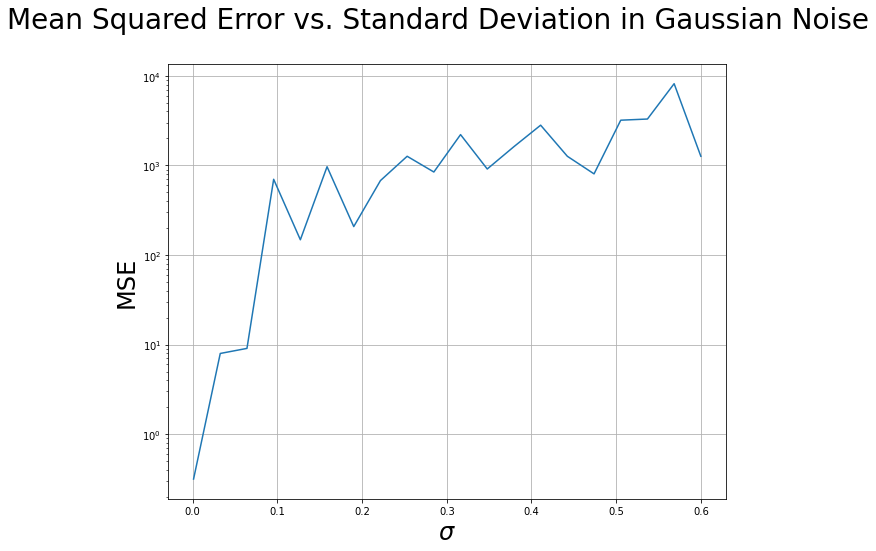

In [9]:
# test of model w/ varying sigma
T = 50
dt = 0.01
trange = np.array([0, T])
#tvals = np.arange(0, T + dt, dt)
tvals = np.linspace(0, T, 5000)
n_of_ic = 300
feature_count = 2
fig, axs = plt.subplots(figsize=(10,8))
netswitch_x0s = (np.random.rand(n_of_ic, feature_count) * 5 - np.random.rand(n_of_ic, feature_count))
sigma = 0.01
sigma_list = np.linspace(0.001, 0.6, 20)
mu = np.zeros(feature_count)
sparse_regression_optimizer = ps.STLSQ(threshold=0.7)
MSE_list = []
netswitch_train_multi = []
integrator_keywords = {}
# 0 for white, 1 for pink, 2 for brown
beta = 0
#integrator_keywords['full_output'] = True
integrator_keywords['rtol'] = 1e-12
integrator_keywords['method'] = 'LSODA'
integrator_keywords['atol'] = 1e-12

print(integrator_keywords)

# creation of TRUE data/solution
for i in range(n_of_ic):     
    netswitch_train_temp = solve_ivp(
        netswitch, trange, netswitch_x0s[i], t_eval=tvals
    ).y.T
    netswitch_train_multi.append(netswitch_train_temp)
print(len(netswitch_train_multi))
print(netswitch_train_multi[0].shape)
# may need to use np.zeros
rmse = np.sqrt(np.square(netswitch_train_multi).sum()) / (len(tvals) * feature_count)
print(f"RMSE = {rmse}")
# train models
for j in range(len(sigma_list)):
    sigma = np.zeros((feature_count, feature_count))
    sigmaVal = sigma_list[j]
    np.fill_diagonal(sigma, sigmaVal)
    #noise = np.random.multivariate_normal(mu, sigma**2, (n_of_ic, len(tvals)))
    noise = cn.powerlaw_psd_gaussian(beta, (n_of_ic, len(tvals), feature_count)) * (sigmaVal + 0.03)
    model = ps.SINDy(feature_names=['u', 'v'], optimizer=sparse_regression_optimizer, feature_library=netswitch_library)
    model.fit(list(netswitch_train_multi + noise), t=dt, multiple_trajectories=True)
    simulations = []
    # create simulations list to hold simulated data for corresponding IC
    for k in range(n_of_ic):
        # problem area with warnings
        netswitch_sim = model.simulate(netswitch_x0s[k], t=tvals, integrator="odeint", integrator_kws=integrator_keywords)
        simulations.append(netswitch_sim) 
    #MSE = np.square(np.subtract(netswitch_train_multi, simulations)).mean()
    MSE = np.square(np.subtract(netswitch_train_multi, simulations)).sum() / (len(tvals) * feature_count)
    MSE_list.append(MSE)
print(sigma_list)
print(MSE_list)
axs.plot(sigma_list, MSE_list)
axs.set(xlabel="$\sigma$", ylabel="MSE")
plt.grid(True)
plt.xlabel("$\sigma$", fontsize=24)
plt.ylabel("MSE", fontsize=24)
fig.suptitle('Mean Squared Error vs. Standard Deviation in Gaussian Noise', fontsize=28)
plt.yscale('log')

500
(500, 2)


C:\Users\UserALai\miniconda3\lib\site-packages\scipy\integrate\_odepack_py.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
C:\Users\UserALai\miniconda3\lib\site-packages\scipy\integrate\_odepack_py.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
C:\Users\UserALai\miniconda3\lib\site-packages\scipy\integrate\_odepack_py.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


[0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1.  1.1 1.2 1.3 1.4 1.5 1.6 1.7 1.8
 1.9 2. ]
[37.3578045243963, 36.37379970329704, 29.841768973750906, 27.676998815722346, 26.937230446945765, 33.23314990542521, 28.331078676135323, 36.061445615625104, 33.96751323446484, 33.07196064090767, 33.496691804194015, 33.00569735154315, 32.235021649114294, 33.119658136402556, 29.076400317310586, 33.83599033230518, 34.974040063692, 28.676922708877836, 234.49789074432988, 33.40674281423231]


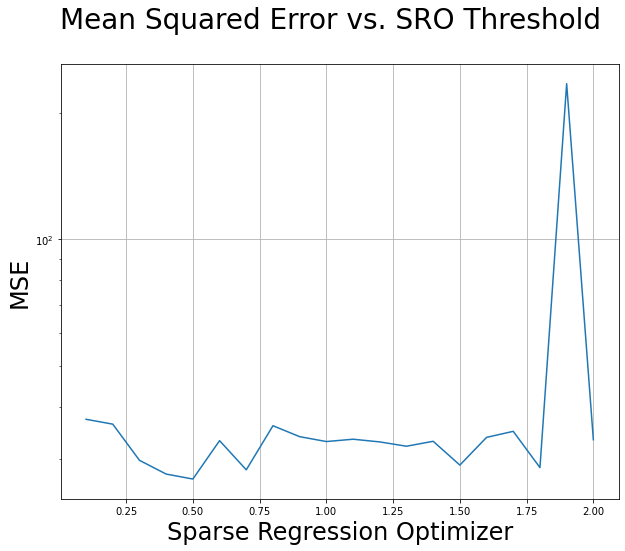

In [70]:
# test of model w/ varying threshold
# edit in progress
T = 50
dt = 0.01
trange = np.array([0, T])
#tvals = np.arange(0, T + dt, dt)
tvals = np.linspace(0, T, 500)
n_of_ic = 500
feature_count = 2
fig, axs = plt.subplots(figsize=(10,8))
netswitch_x0s = (np.random.rand(n_of_ic, feature_count) * 5 - np.random.rand(n_of_ic, feature_count))
#sigma = 0.01
threshold_list = np.linspace(0.1, 2, 20)
mu = np.zeros(feature_count)

MSE_list = []
netswitch_train_multi = []

# creation of TRUE data/solution
for i in range(n_of_ic):
    netswitch_train_temp = solve_ivp(
        netswitch, trange, netswitch_x0s[i], t_eval=tvals
    ).y.T
    netswitch_train_multi.append(netswitch_train_temp)
print(len(netswitch_train_multi))
print(netswitch_train_multi[0].shape)
sigma = np.zeros((feature_count, feature_count))
sigmaVal = 0.2
np.fill_diagonal(sigma, sigmaVal)
# figure out sigma threshold with rmse for prev. cell 
# train models
for j in range(len(threshold_list)):
    sparse_regression_optimizer = ps.STLSQ(threshold=threshold_list[j])
    model = ps.SINDy(feature_names=['u', 'v'], optimizer=sparse_regression_optimizer, feature_library=netswitch_library)
    noise = np.random.multivariate_normal(mu, sigma**2, (n_of_ic, len(tvals)))
    model.fit(list(netswitch_train_multi + noise), t=dt, multiple_trajectories=True)
    simulations = []
    # create simulations list to hold simulated data for corresponding IC
    for k in range(n_of_ic):
        netswitch_sim = model.simulate(netswitch_x0s[k], t=tvals, integrator="odeint")
        simulations.append(netswitch_sim) 
    #MSE = np.square(np.subtract(netswitch_train_multi, simulations)).mean()
    MSE = np.square(np.subtract(netswitch_train_multi, simulations)).sum() / (feature_count * len(tvals))
    MSE_list.append(MSE)
print(threshold_list)
print(MSE_list)
axs.plot(threshold_list, MSE_list)
axs.set(xlabel="Sparse Regression Optimizer", ylabel="MSE")
plt.grid(True)
plt.xlabel("Sparse Regression Optimizer", fontsize=24)
plt.ylabel("MSE", fontsize=24)
fig.suptitle('Mean Squared Error vs. SRO Threshold', fontsize=28)
plt.savefig("C:/Users/UserALai/Downloads\img.svg", bbox_inches='tight')
plt.yscale('log')

## Repressilator/Gene Network Clock

In [6]:
# General from of equations; reference pg 112
# mdot_i = -m_i + (alpha / (1+p_j**n)) + a0
# pdot_i = -beta * (p_i - m_i)
# if i = lacI, tetR, cl
# then j = cl, lacI, tetR

# is there a better way of doing this? kinda spaghetti code 
#mdot_lacI = lambda m_lacI, m_tetR, m_cl, p_lacI, p_tetR, p_cl: -m_lacI + (alpha / (1+p_cl**n)) + a0
#mdot_tetR = lambda m_lacI, m_tetR, m_cl, p_lacI, p_tetR, p_cl: -m_tetR + (alpha / (1+p_lacI**n)) + a0
#mdot_cl = lambda m_lacI, m_tetR, m_cl, p_lacI, p_tetR, p_cl: -m_cl + (alpha / (1+p_tetR**n)) + a0
#pdot_lacI = lambda m_lacI, m_tetR, m_cl, p_lacI, p_tetR, p_cl: -beta * (p_lacI - m_lacI)
#pdot_tetR = lambda m_lacI, m_tetR, m_cl, p_lacI, p_tetR, p_cl: -beta * (p_tetR - m_tetR)
#pdot_cl = lambda m_lacI, m_tetR, m_cl, p_lacI, p_tetR, p_cl: -beta * (p_cl - m_cl)

alpha=50
a0=0
n=2
beta=0.2
# x in form:
# [m_lacI, m_tetR, m_cl, p_lacI, p_tetR, p_cl]
# [0     , 1     , 2   , 3     , 4     , 5   ]
def repressilator(t, x):
    return [
        -x[0] + (alpha / (1 + x[5]**n)) + a0,
        -x[1] + (alpha / (1+x[3]**n)) + a0,
        -x[2] + (alpha / (1+x[4]**n)) + a0,
        -beta * (x[3] - x[0]),
        -beta * (x[4] - x[1]),
        -beta * (x[5] - x[2])
    ]

T = 300
dt = 0.01
trange = np.array([0, T])
tvals = np.arange(0, T + dt, dt)
x0 = np.array([0.2, 0.1, 0.3, 0.1, 0.4, 0.5])
x_train1 = solve_ivp(repressilator, trange, x0, t_eval=tvals).y

alpha=50
a0=1
n=2
beta=0.2
#T=100
trange2 = np.array([0, T])
tvals2 = np.arange(0, T + dt, dt)

x_train2 = solve_ivp(repressilator, trange2, x0, t_eval=tvals2).y
"""
fig, axs = plt.subplots(1, 2, figsize=(20, 8))
axs[0].plot(tvals, x_train1[0, ], "r", label="$m_{lacI}$",)
axs[0].plot(tvals, x_train1[1, :], "g", label="$m_{tetR}$")
axs[0].plot(tvals, x_train1[2, :], "b", label="$m_{cl}$")
axs[0].plot(tvals, x_train1[3, :], "r--", label="$p_{lacI}$")
axs[0].plot(tvals, x_train1[4, :], "g--", label="$p_{tetR}$")
axs[0].plot(tvals, x_train1[5, :], "b--", label="$p_{cl}$")

axs[0].legend()
axs[0].set(xlabel="t", title="Oscillatory Repressilator solutions")

axs[1].plot(tvals2, x_train2[0, ], "r", label="$m_{lacI}$",)
axs[1].plot(tvals2, x_train2[1, :], "g", label="$m_{tetR}$")
axs[1].plot(tvals2, x_train2[2, :], "b", label="$m_{cl}$")
axs[1].plot(tvals2, x_train2[3, :], "r--", label="$p_{lacI}$")
axs[1].plot(tvals2, x_train2[4, :], "g--", label="$p_{tetR}$")
axs[1].plot(tvals2, x_train2[5, :], "b--", label="$p_{cl}$")

axs[1].legend()
axs[1].set(xlabel="t", title="Convergent Repressilator solutions")
"""

'\nfig, axs = plt.subplots(1, 2, figsize=(20, 8))\naxs[0].plot(tvals, x_train1[0, ], "r", label="$m_{lacI}$",)\naxs[0].plot(tvals, x_train1[1, :], "g", label="$m_{tetR}$")\naxs[0].plot(tvals, x_train1[2, :], "b", label="$m_{cl}$")\naxs[0].plot(tvals, x_train1[3, :], "r--", label="$p_{lacI}$")\naxs[0].plot(tvals, x_train1[4, :], "g--", label="$p_{tetR}$")\naxs[0].plot(tvals, x_train1[5, :], "b--", label="$p_{cl}$")\n\naxs[0].legend()\naxs[0].set(xlabel="t", title="Oscillatory Repressilator solutions")\n\naxs[1].plot(tvals2, x_train2[0, ], "r", label="$m_{lacI}$",)\naxs[1].plot(tvals2, x_train2[1, :], "g", label="$m_{tetR}$")\naxs[1].plot(tvals2, x_train2[2, :], "b", label="$m_{cl}$")\naxs[1].plot(tvals2, x_train2[3, :], "r--", label="$p_{lacI}$")\naxs[1].plot(tvals2, x_train2[4, :], "g--", label="$p_{tetR}$")\naxs[1].plot(tvals2, x_train2[5, :], "b--", label="$p_{cl}$")\n\naxs[1].legend()\naxs[1].set(xlabel="t", title="Convergent Repressilator solutions")\n'

## Morris-Lecar Model
    

[Text(0.5, 0, 't'), Text(0.5, 1.0, 'Morris-Lecar solutions')]

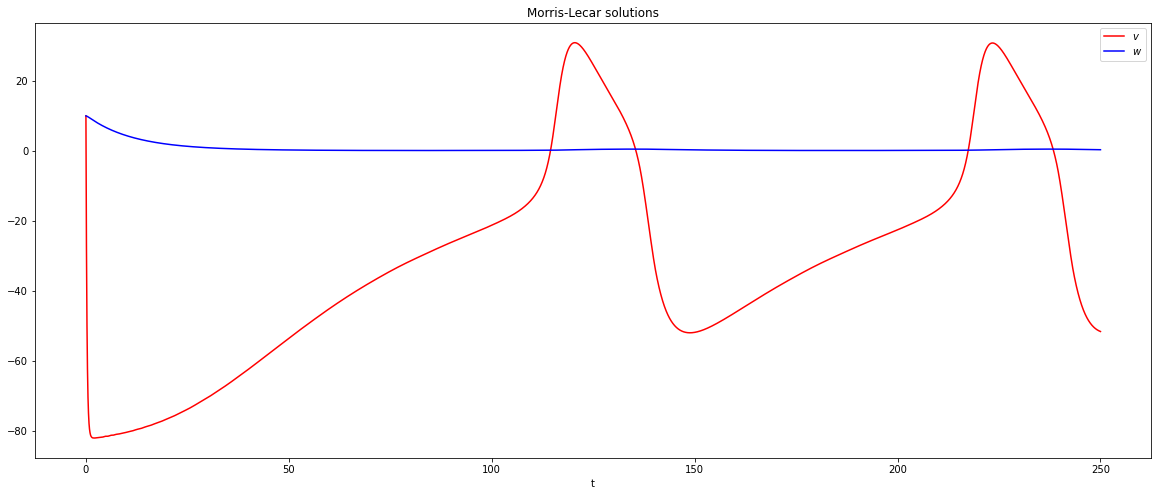

In [5]:
gCa, gK, gL, vCa, vK, vL, C, phi, i, v_1, v_2, v_3, v_4 = 4.4, 8, 2, 120, -84, -60, 20, 0.04, 90, -1.2, 18, 2, 30
# helper functions v ^ parameters
m_inf = lambda v: 0.5 * (1 + np.tanh((v - v_1) / v_2))
w_inf = lambda v: 0.5 * (1 + np.tanh((v - v_3) / v_4))
t_w = lambda v: 1 / (np.cosh((v-v_3) / (2 * v_4)))

# x = [v, w]
def morris_lecar(t, x):
    return [
        (1/C) * (i-gCa * m_inf(x[0]) * (x[0] - vCa)-gK * x[1] * (x[0]-vK) - gL * (x[0]-vL)),
        (1/t_w(x[0])) * (phi * (w_inf(x[0]) - x[1]))
    ]

T = 250
dt = 0.01
trange = np.array([0, T])
tvals = np.arange(0, T + dt, dt)
x0 = np.array([10, 10])

MorLec_train = solve_ivp(morris_lecar, trange, x0, t_eval=tvals).y

fig, axs = plt.subplots(figsize=(20, 8))
axs.plot(tvals, MorLec_train[0, ], "r", label="$v$")
axs.plot(tvals, MorLec_train[1, ], "b", label="$w$")


axs.legend()
axs.set(xlabel="t", title="Morris-Lecar solutions")

In [6]:
gCa, gK, gL, vCa, vK, vL, C, phi, i, v_1, v_2, v_3, v_4 = 4.4, 8, 2, 120, -84, -60, 20, 0.04, 90, -1.2, 18, 2, 30
# helper functions v ^ parameters
m_inf = lambda v: 0.5 * (1 + np.tanh((v - v_1) / v_2))
w_inf = lambda v: 0.5 * (1 + np.tanh((v - v_3) / v_4))
t_w = lambda v: 1 / (np.cosh((v-v_3) / (2 * v_4)))

# x = [v, w]
def morris_lecar(t, x):
    return [
        (1/C) * (i-gCa * m_inf(x[0]) * (x[0] - vCa)-gK * x[1] * (x[0]-vK) - gL * (x[0]-vL)),
        (1/t_w(x[0])) * (phi * (w_inf(x[0]) - x[1]))
    ]

# morris-lecar library functions
library_functions = [
    lambda x: x,
    lambda x: 1 / (1 + x**1),
    lambda x: 1 / (1 + x**2),
    lambda x: 1 / (1 + x**3),
    lambda x: 1 / (1 + x**4),
    lambda x: 1 / (1 + x**5)
]
library_function_names = [
    lambda x: x,
    lambda x: '1/(1 + ' + x + '^1)',
    lambda x: '1/(1 + ' + x + '^2)',
    lambda x: '1/(1 + ' + x + '^3)',
    lambda x: '1/(1 + ' + x + '^4)',
    lambda x: '1/(1 + ' + x + '^5)'
]
netswitch_library = ps.CustomLibrary(
    library_functions=library_functions, function_names=library_function_names
)

In [ ]:
# actual test of model
T = 250
dt = 0.01
trange = np.array([0, T])
#tvals = np.arange(0, T + dt, dt)
tvals = np.linspace(0, T, 100)
n_of_ic = 500
feature_count = 2
fig, axs = plt.subplots(figsize=(10,8))
netswitch_x0s = (np.random.rand(n_of_ic, feature_count) * 10 - np.random.rand(n_of_ic, feature_count))
sigma = 0.01
sigma_list = np.linspace(0.001, 0.6, 5)
mu = np.zeros(feature_count)

MSE_list = []
morlec_train_multi = []

# creation of TRUE data/solution
for i in range(n_of_ic):     
    morlec_train_temp = solve_ivp(
        netswitch, trange, netswitch_x0s[i], t_eval=tvals
    ).y.T
    netswitch_train_multi.append(netswitch_train_temp)
print(len(netswitch_train_multi))
print(netswitch_train_multi[0].shape)

# train models
for j in range(len(sigma_list)):
    sigma = np.zeros((feature_count, feature_count))
    sigmaVal = sigma_list[j]
    np.fill_diagonal(sigma, sigmaVal)
    noise = np.random.multivariate_normal(mu, sigma**2, (n_of_ic, len(tvals)))
    model = ps.SINDy(feature_names=['u', 'v'], optimizer=sparse_regression_optimizer, feature_library=netswitch_library)
    model.fit(list(netswitch_train_multi + noise), t=dt, multiple_trajectories=True)
    simulations = []
    # create simulations list to hold simulated data for corresponding IC
    for k in range(n_of_ic):
        netswitch_sim = model.simulate(netswitch_x0s[k], t=tvals, integrator="odeint")
        simulations.append(netswitch_sim) 
    MSE = np.square(np.subtract(netswitch_train_multi, simulations)).mean()
    MSE_list.append(MSE)
print(sigma_list)
print(MSE_list)
axs.plot(sigma_list, MSE_list)
axs.set(xlabel="$\sigma$", ylabel="MSE", title="Mean Squared Error vs. Standard Deviation in Gaussian Noise")
plt.grid(True)
plt.xlabel("$\sigma$", fontsize=24)
plt.ylabel("MSE", fontsize=24)
fig.suptitle('Mean Squared Error vs. Standard Deviation in Gaussian Noise', fontsize=28)